In [21]:
# Make maps

It would be great if you could locate the HPPs on a map with rivers shown and a few key cities for orientation. We could display them with a small blue triangle, with the base towards downstream direction, and a number. Similarly, please also include the gauging stations mentioned in the same sheet, eg with a red dot cum small circle plus a number. We could then put a list with numbers and names on the side.

## Installation

Be careful with the version of the libraries for geopandas and fiona. Worked with the following versions:
- geopandas==0.14.1
- fiona==1.8.4

In [22]:
import fiona
import geopandas as gpd

# Display versions
print(f"Fiona version: {fiona.__version__}")
print(f"Geopandas version: {gpd.__version__}")

Fiona version: 1.9.6
Geopandas version: 0.14.4


/var/folders/p9/3r4_fgzd72j7b469xxshgfnh0000gn/T/ipykernel_52262/3230550718.py:30: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  path = gpd.datasets.get_path('naturalearth_lowres')
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


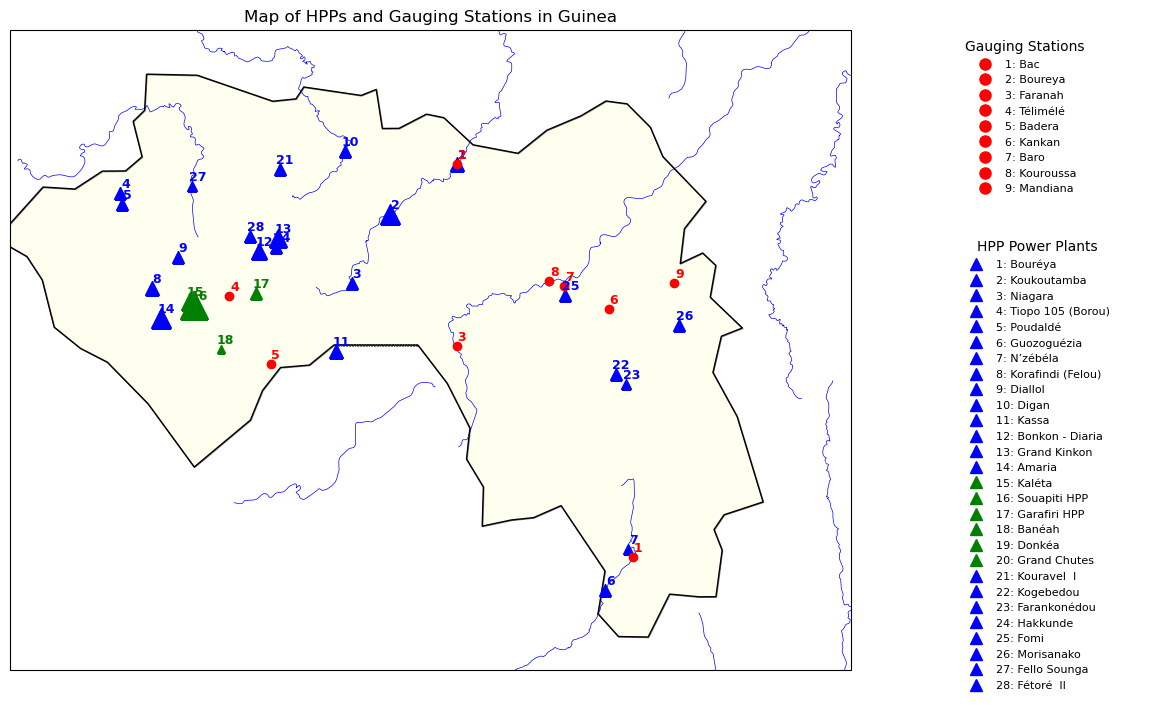

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from adjustText import adjust_text
import numpy as np

# Load your HPP and gauging stations data (replace 'your_file.csv' with your actual file)
import pandas as pd

use_adjust_text, name_on_map = False, False
hpp_data = pd.read_csv('hpp_location.csv')  # Columns: id, name, latitude, longitude
gauging_data = pd.read_csv('station_location.csv')  # Columns: id, name, latitude, longitude

# Convert to GeoDataFrames
hpp_gdf = gpd.GeoDataFrame(
    hpp_data,
    geometry=gpd.points_from_xy(hpp_data['longitude'], hpp_data['latitude']),
    crs="EPSG:4326"
)

gauging_gdf = gpd.GeoDataFrame(
    gauging_data,
    geometry=gpd.points_from_xy(gauging_data['longitude'], gauging_data['latitude']),
    crs="EPSG:4326"
)

# Load country boundaries
path = gpd.datasets.get_path('naturalearth_lowres')
country_boundary = gpd.read_file(path)

# Filter for Guinea
guinea = country_boundary[country_boundary['name'] == 'Guinea']

# Plotting
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes([0.1, 0.1, 0.65, 0.8], projection=ccrs.PlateCarree())  # Main map axis
legend_ax1 = fig.add_axes([0.8, 0.55, 0.15, 0.35])  # Separate axis for gauging station legend
legend_ax2 = fig.add_axes([0.8, 0.3, 0.15, 0.35])  # Separate axis for HPP legend


ax.set_extent([-15, -7, 7, 13], crs=ccrs.PlateCarree())  # Set to Guinea's extent

# Add rivers and country boundaries
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m'),
               edgecolor='blue', facecolor='none', linewidth=0.5)
guinea.boundary.plot(ax=ax, edgecolor='black', linewidth=1)


# Dissolve into main regions by grouping by "region" (if available) or simply use the full geometry
# Since no specific shapefile for regions is available, we use the full country geometry
guinea_regions = guinea.explode(index_parts=False)  # Ensure multi-parts are handled correctly
# Plot the regions as a background color
guinea_regions.plot(ax=ax, color='lightyellow', edgecolor='black', alpha=0.5, transform=ccrs.PlateCarree())


# Normalize the size column for marker sizes
max_marker_size = 20  # Maximum marker size
min_marker_size = 6   # Minimum marker size
hpp_gdf['normalized_size'] = np.interp(hpp_gdf['size'], 
                                       (hpp_gdf['size'].min(), hpp_gdf['size'].max()), 
                                       (min_marker_size, max_marker_size))

# Legend entries
# Separate legend entries for gauging stations and HPPs
gauging_entries = []
hpp_entries = []

# Plot HPPs
hpp_texts = []
for i, row in hpp_gdf.iterrows():
    color = 'green' if row['attribute'] == 'Existing' else 'blue'
    ax.plot(row.geometry.x, row.geometry.y, '^', color=color, 
            markersize=row['normalized_size'], 
            label='HPP' if i == 0 else "", 
            transform=ccrs.PlateCarree())
    name = row['name'].split(' (')[0].split(' +')[0]
    if name_on_map:
        hpp_texts.append(ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, f"{name}", 
                                fontsize=8, ha='center', transform=ccrs.PlateCarree()))
    else:
        ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, f"{i + 1}", fontsize=9, ha='center', transform=ccrs.PlateCarree(),
                fontweight='bold', color=color)
        # Add names to the legend
        hpp_entries.append((f"{i + 1}: {row['name']}", color))
            
# Plot gauging stations
gauging_texts = []
for i, row in gauging_gdf.iterrows():
    ax.plot(row.geometry.x, row.geometry.y, 'ro', markersize=6, 
            label='Gauging Station' if i == 0 else "", 
            transform=ccrs.PlateCarree())
    name = row['name'].split(' (')[0].split(' +')[0]
    if name_on_map:
        gauging_texts.append(ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, f"{name}", 
                                    fontsize=8, ha='center', transform=ccrs.PlateCarree()))
    else:
        ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, f"{i + 1}", fontsize=9, ha='center', transform=ccrs.PlateCarree(),
                fontweight='bold', color='red')
        # Add names to the legend
        gauging_entries.append((f"{i + 1}: {row['name']}", 'red'))


# Configure the gauging station legend axis
legend_ax1.axis('off')  # Turn off the axis for the legend
gauging_handles = [
    plt.Line2D([], [], color=color, marker='o', linestyle='', markersize=8, label=label)
    for label, color in gauging_entries
]
legend_ax1.legend(handles=gauging_handles, loc='upper left', fontsize=8, title="Gauging Stations", title_fontsize=10, frameon=False)

# Configure the HPP legend axis
legend_ax2.axis('off')  # Turn off the axis for the legend
hpp_handles = [
    plt.Line2D([], [], color=color, marker='^', linestyle='', markersize=8, label=label)
    for label, color in hpp_entries
]
legend_ax2.legend(handles=hpp_handles, loc='upper left', fontsize=8, title="HPP Power Plants", title_fontsize=10, frameon=False)



# Legend and title
ax.set_title("Map of HPPs and Gauging Stations in Guinea")
plt.show()

In [24]:
legend_entries

[('1: Bouréya', 'blue'),
 ('2: Koukoutamba', 'blue'),
 ('3: Niagara', 'blue'),
 ('4: Tiopo 105 (Borou)', 'blue'),
 ('5: Poudaldé', 'blue'),
 ('6: Guozoguézia', 'blue'),
 ('7: N’zébéla', 'blue'),
 ('8: Korafindi (Felou)', 'blue'),
 ('9: Diallol', 'blue'),
 ('10: Digan', 'blue'),
 ('11: Kassa', 'blue'),
 ('12: Bonkon - Diaria', 'blue'),
 ('13: Grand Kinkon', 'blue'),
 ('14: Amaria', 'blue'),
 ('15: Kaléta', 'green'),
 ('16: Souapiti HPP', 'green'),
 ('17: Garafiri HPP', 'green'),
 ('18: Banéah', 'green'),
 ('19: Donkéa', 'green'),
 ('20: Grand Chutes', 'green'),
 ('21: Kouravel  I', 'blue'),
 ('22: Kogebedou', 'blue'),
 ('23: Farankonédou', 'blue'),
 ('24: Hakkunde', 'blue'),
 ('25: Fomi', 'blue'),
 ('26: Morisanako', 'blue'),
 ('27: Fello Sounga', 'blue'),
 ('28: Fétoré  II', 'blue'),
 ('1: Bac', 'red'),
 ('2: Boureya', 'red'),
 ('3: Faranah', 'red'),
 ('4: Télimélé', 'red'),
 ('5: Badera', 'red'),
 ('6: Kankan', 'red'),
 ('7: Baro', 'red'),
 ('8: Kouroussa', 'red'),
 ('9: Mandiana', 'r

In [25]:
hpp_gdf['attribute']

0     S-BF1-3711-1
1     S-BF1-7000-1
2     S-BF2-0700-1
3     A-COG-0550-1
4     A-COG-0570-1
5     A-DIA-7030-1
6     A-DIA-9011-2
7     A-FAT-4300-1
8     A-FAT-4705-3
9     G-GAM-9012-1
10    A-KAB-6303-1
11    A-KON-8053-1
12    A-KON-8070-2
13    A-KON-1030-1
14        Existing
15        Existing
16        Existing
17        Existing
18        Existing
19        Existing
20    A-TOM-9701-4
21    N-MIL-7701-2
22    N-MIL-7703-1
23    A-KON-8061-1
24    N-NIA-1003-1
25    N-SK1-0905-1
26    A-TOM-6301-1
27    A-KON-9201-2
Name: attribute, dtype: object

In [26]:
import os
os.path.isfile(path)

True

In [27]:
import geopandas as gpd
path = gpd.datasets.get_path('naturalearth_lowres')
print(path)


/opt/anaconda3/envs/esmap_env/lib/python3.9/site-packages/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.shp


/var/folders/p9/3r4_fgzd72j7b469xxshgfnh0000gn/T/ipykernel_52262/3014588908.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  path = gpd.datasets.get_path('naturalearth_lowres')
